<div style="border: 1px solid red; padding: 10px; border-radius: 5px;">

# Задача
В этой работе вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

В этой задаче для обучения будут использовать 2 алгоритма:
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

</div>


# Решение

In [45]:
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
df = pd.read_csv("D:\\ds\\data.adult.csv")

<div style="border: 1px solid red; padding: 10px; border-radius: 5px;">

## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения (здесь они обозначены как "?"). Удалите из выборки все объекты с пропусками.
2. Выделите 60% выборки для обучения и дальнейшего анализа.
3. Обратите внимание, что не все признаки являются вещественными (числовыми). Сначала их необходимо проанализировать и по необходимости предобработать. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную и преобразуйте к бинарному формату (НЕ забудьте удалить ее из датасета, когда будете обучать модель).

</div>

In [3]:
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def prep(dataframe):
    dataframe = dataframe.drop_duplicates().reset_index(drop=True)
    dataframe.columns = [camel_to_snake(col) for col in dataframe.columns]
    dataframe.columns = dataframe.columns.str.replace(' ', '_')
    dataframe.columns = dataframe.columns.str.replace('-', '_')
    return dataframe

def get_info(dataframe):
    display(dataframe.head(5))
    print('*'*50)
    dataframe.info()
    print('*'*50)
    print(f"Явных дубликатов: {dataframe.duplicated().sum()}")
    print('*'*39)
    print('Пропусков в колонках:')
    missing_counts = dataframe.isna().sum()
    percentage_missing = (missing_counts / dataframe.shape[0]) * 100
    print(pd.concat([missing_counts, percentage_missing.round(1)], 
                    axis=1, keys=['Количество', 'Доля, %']))

def get_uniques(dataframe):
    columns = dataframe.columns
    uniques = [dataframe[col].dropna().unique().tolist() for col in columns]
    data_types = [dataframe[col].dtype for col in columns]
    result_df = pd.DataFrame(
        {'Столбцы': columns,
         'Уникальные значения': uniques, 
         'Тип данных': data_types})
    return result_df

In [4]:
df.replace("?", pd.NA, inplace=True)
df.rename(columns={">50K,<=50K": "income"}, inplace=True)

In [5]:
get_info(df)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       15351 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education-num   16280 non-null  int64 
 5   marital-status  16280 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital-gain    16280 non-null  int64 
 11  capital-loss    16280 non-null  int64 
 12  hours-per-week  16280 non-null  int64 
 13  income          16280 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB
**************************************************
Явных дубликатов: 12
**************

In [6]:
df = prep(df)
df.dropna(inplace=True)

In [7]:
get_uniques(df)

,Столбцы,Уникальные значения,Тип данных
0,age,"[34, 40, 36, 22, 47, 18, 31, 25, 53, 19, 44, 2...",int64
1,workclass,"[Local-gov, Private, Federal-gov, Self-emp-inc...",object
2,fnlwgt,"[284843, 190290, 177858, 184756, 149700, 44677...",int64
3,education,"[HS-grad, Some-college, Bachelors, Assoc-acdm,...",object
4,education_num,"[9, 10, 13, 12, 8, 16, 2, 4, 14, 3, 7, 5, 11, ...",int64
5,marital_status,"[Never-married, Divorced, Married-civ-spouse, ...",object
6,occupation,"[Farming-fishing, Sales, Prof-specialty, Tech-...",object
7,relationship,"[Not-in-family, Own-child, Husband, Unmarried,...",object
8,race,"[Black, White, Amer-Indian-Eskimo, Asian-Pac-I...",object
9,sex,"[Male, Female]",object


Признак `fnlwgt` (final weight) в этом датасете (из набора Adult Census Income) — это взвешенный коэффициент, который показывает, сколько людей в общей популяции соответствует данному наблюдению.

Грубо говоря, если у кого-то fnlwgt = 200000, это значит, что этот человек репрезентирует примерно 200000 людей с такими же характеристиками (по возрасту, образованию, профессии и т. д.) в генеральной совокупности.

Не используется напрямую при построении моделей машинного обучения, потому что он не является предиктором дохода, поэтому его можно удалить.

`education_num` — это числовой эквивалент уровня образования. Этот признак в датасете Adult Census Income соответствует категории education, но в числовом формате. Столбец `education` можно удалить, так как он дублирует информацию.

In [23]:
df = df.drop(columns=['education', 'fnlwgt'])

Перекодируем бинарные категориальные признаки `sex` и `income`.

In [8]:
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

<div style="border: 1px solid red; padding: 10px; border-radius: 5px;">

При обучении алгоритмов стоит обращать внимание не только на их качество, но и каким образом они работают с данными. Давайте посмотрим на значения самих признаков.

Что можете сказать о разбросе данных и сбалансированности выборки? В каком диапазоне лежат исследуемые признаки?

</div>

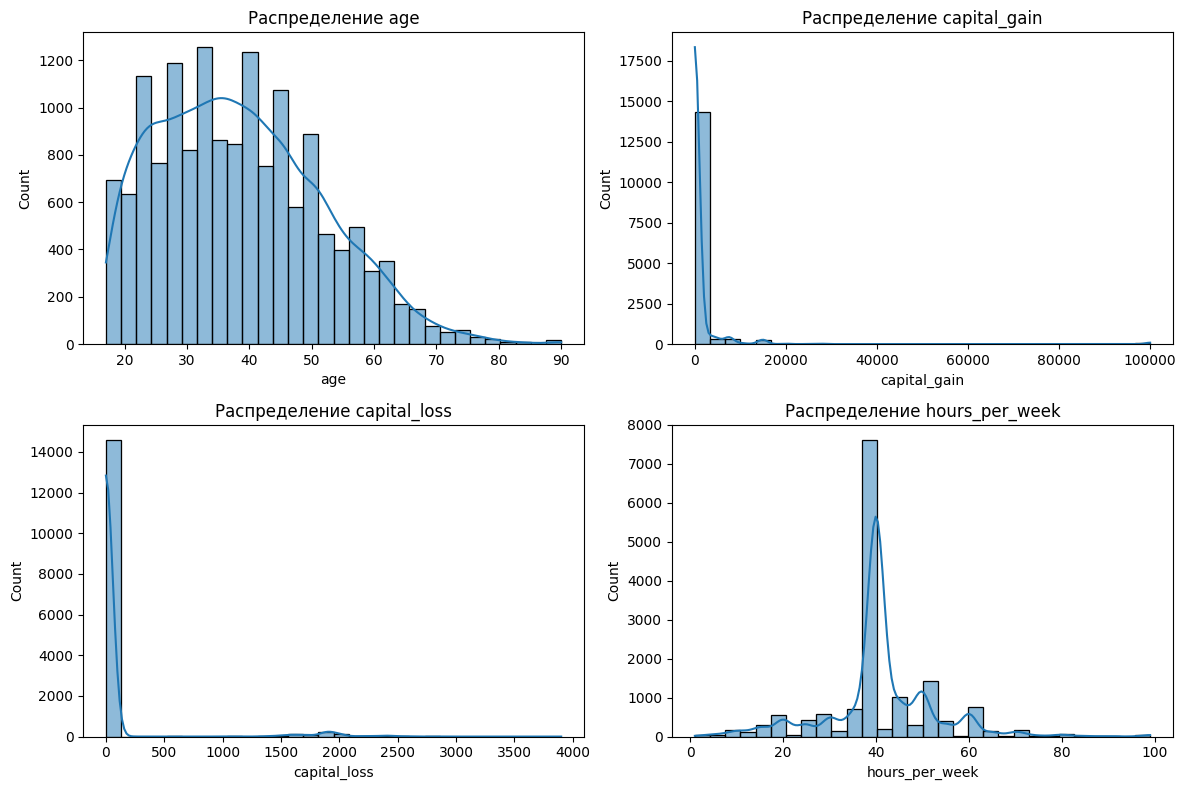

In [9]:
continuous_features = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']

plt.figure(figsize=(12, 8))

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f"Распределение {feature}")

plt.tight_layout()
plt.show()

**Характеристика распределений:**
- Признак `age`:
    - Распределение: похоже на нормальное с небольшим смещением вправо (скошенность в сторону старших возрастов).
    - Диапазон: от 18 до 90 лет.
    - Разброс: данные распределены относительно равномерно, с пиком в районе 30-40 лет.
    - Сбалансированность: выборка сбалансирована по возрасту, нет явных перекосов.
- Признак `capital_gain`:
    - Распределение: cильно скошенное вправо (большинство значений близко к 0).
    - Диапазон: от 0 до 100000.
    - Разброс: большинство значений сосредоточено в районе 0, с редкими выбросами до 100000.
    - Сбалансированность: выборка несбалансирована - большинство наблюдений имеют нулевые или близкие к нулю значения.
- Признак `capital_loss`:
    - Распределение: cильно скошенное вправо (большинство значений близко к 0).
    - Диапазон: от 0 до 4000.
    - Разброс: большинство значений сосредоточено в районе 0, с редкими выбросами до 4000.
    - Сбалансированность: выборка несбалансирована - большинство наблюдений имеют нулевые или близкие к нулю значения.
- Признак `hours_per_week`:
    - Распределение: похоже на нормальное с пиком в районе 40 часов.
    - Диапазон: от 0 до 100 часов.
    - Разброс: данные распределены равномерно, с явным пиком на 40 часах (стандартная рабочая неделя).
    - Сбалансированность: выборка сбалансирована, но есть небольшой перекос в сторону 40 часов.

<div style="border: 1px solid red; padding: 10px; border-radius: 5px;">

## Добавление категориальных признаков

Добавим к предобработанным вещественным признакам категориальные. Но для начала их тоже необходимо предобработать.

Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) / [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn).

После преобразования категориальных признаков, добавьте их к вещественным предобработанным данным для обучения.

>PS Напоминаю, что важно удалить колонку с целевым значением

</div>

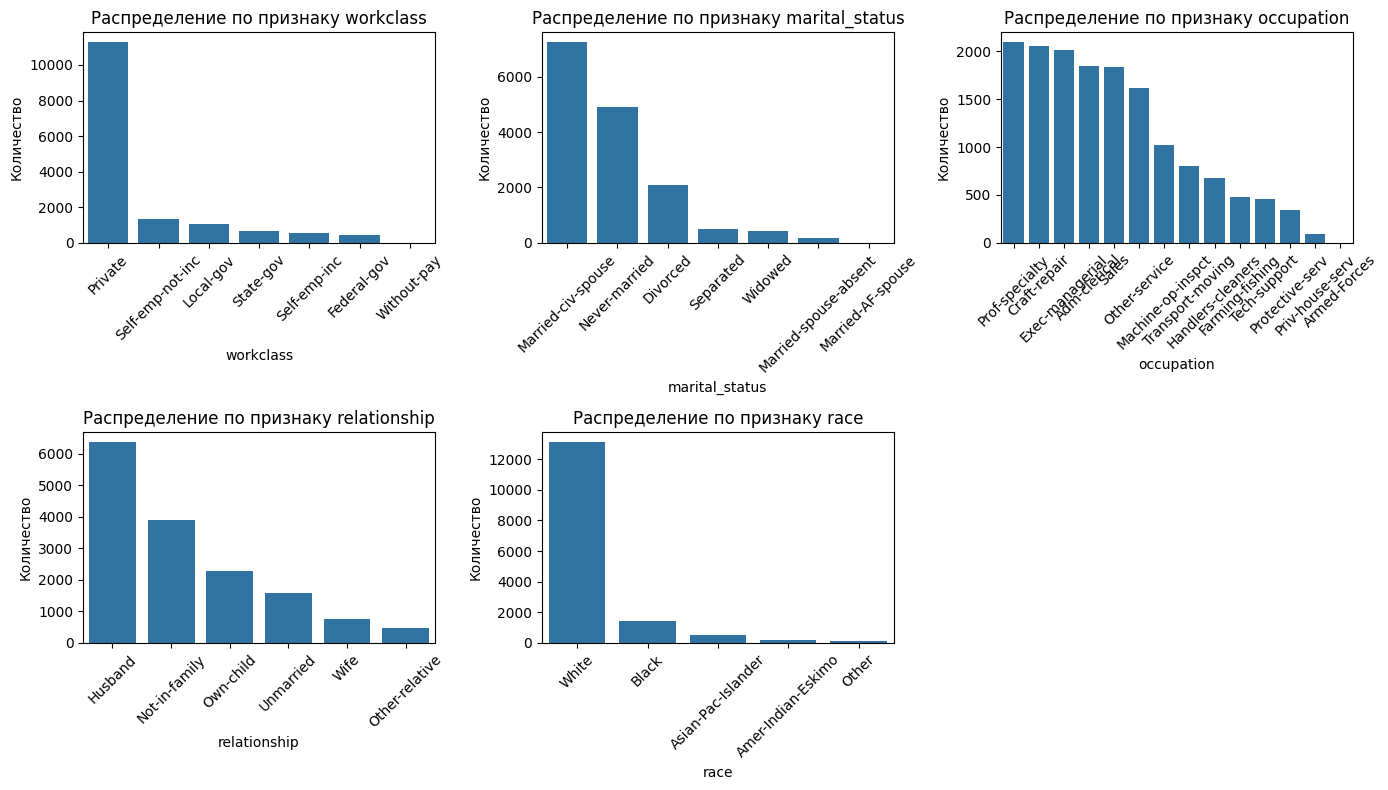

In [14]:
plt.figure(figsize=(14, 8))

features = ['workclass', 'marital_status', 'occupation', 'relationship', 'race']

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index)
    plt.title(f'Распределение по признаку {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Понизим размерность где можно.

In [15]:
df['workclass'] = df['workclass'].replace({
    'Local-gov': 'gov',
    'Federal-gov': 'gov',
    'State-gov': 'gov',
    'Self-emp-inc': 'self_emp',
    'Self-emp-not-inc': 'self_emp'
})

df['marital_status'] = df['marital_status'].replace({
    'Married-civ-spouse': 'married',
    'Separated': 'married',
    'Married-spouse-absent': 'married',
    'Married-AF-spouse': 'married',
    'Never-married': 'not_married',
    'Divorced': 'not_married',
    'Widowed': 'not_married'
})

df['marital_status'] = df['marital_status'].map({'married': 1, 'not_married': 0})

df['race'] = df['race'].replace({
    'Black': 'Other',
    'Amer-Indian-Eskimo': 'Other',
    'Asian-Pac-Islander': 'Other'
})

df['race'] = df['race'].map({'White': 1, 'Other': 0})

df['relationship'] = df['relationship'].replace({
    'Husband': 'spouse',
    'Wife': 'spouse',
    'Own-child': 'own_child',
    'Not-in-family': 'other_family',
    'Other-relative': 'other_family'
})

df['occupation'] = df['occupation'].replace({
    'Farming-fishing': 'manual_service',
    'Craft-repair': 'manual_service',
    'Handlers-cleaners': 'manual_service',
    'Machine-op-inspct': 'manual_service',
    'Transport-moving': 'manual_service',
    'Priv-house-serv': 'manual_service',
    'Adm-clerical': 'admin_managerial',
    'Exec-managerial': 'admin_managerial',
    'Prof-specialty': 'professional_tech',
    'Tech-support': 'professional_tech',
    'Sales': 'sales',
    'Protective-serv': 'other_service',
    'Other-service': 'other_service',
    'Armed-Forces': 'other_service'
})

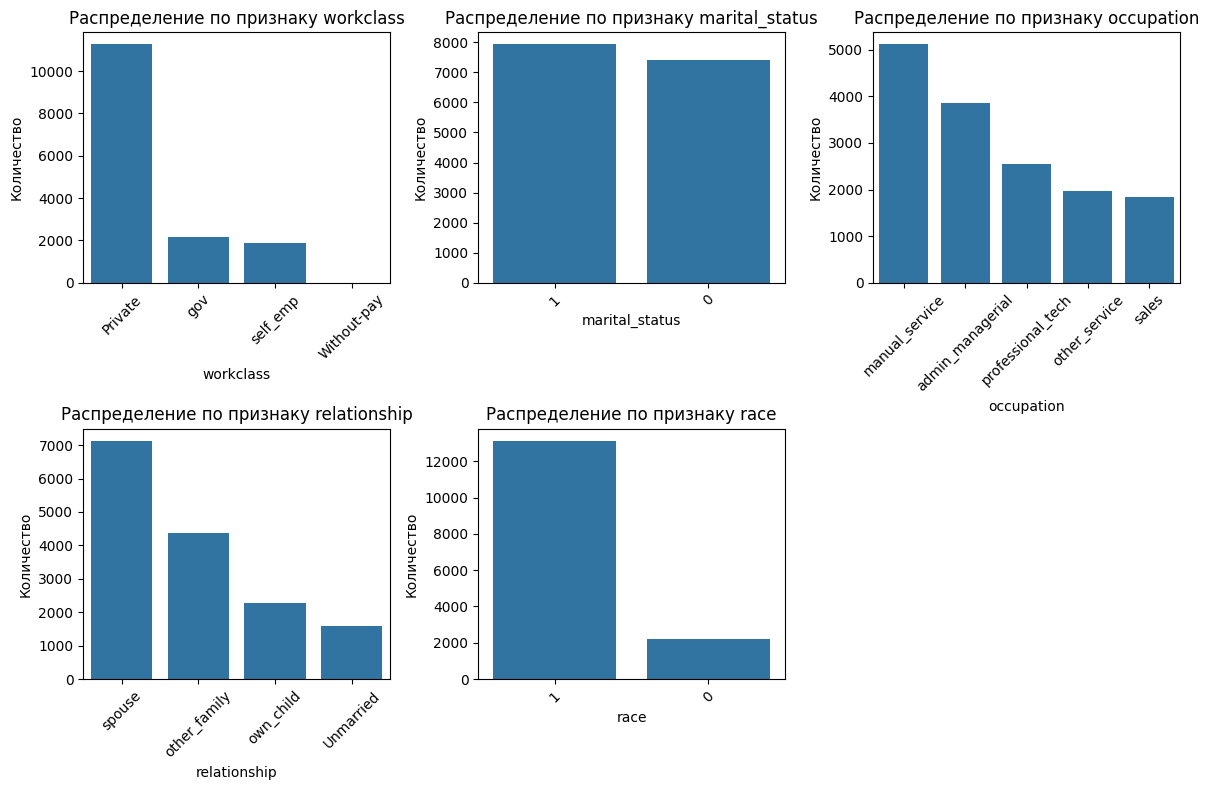

In [16]:
plt.figure(figsize=(12, 8))

features = ['workclass', 'marital_status', 'occupation', 'relationship', 'race']

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index)
    plt.title(f'Распределение по признаку {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Теперь `workclass`, `occupation` и `relationship` можно преобразовать через One-Hot Encoding.

In [17]:
df = pd.get_dummies(df, columns=['workclass', 'occupation', 'relationship'], drop_first=True, dtype=int)

In [26]:
X = df.drop(columns='income')
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

<div style="border: 1px solid red; padding: 10px; border-radius: 5px;">

## Обучение классификаторов

В начале посмотрим, как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 2 алгоритма:
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

<div style="border: 1px solid red; padding: 10px; border-radius: 5px;">

Для начала обучим дерево, выберем один гиперпараметр, который будем оптимизировать, — глубина дерева (*max_depth*).
 
Остальные параметры оставляйте в значениях по умолчанию.

Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

</div>

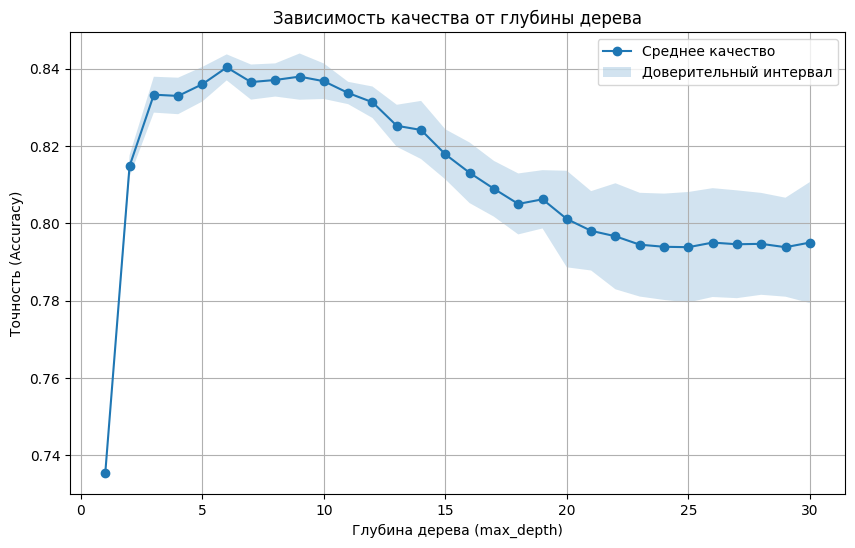

Оптимальная глубина дерева: 6


In [ ]:
max_depths = np.arange(1, 31)
mean_scores = []
std_scores = []

for depth in max_depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.figure(figsize=(10, 6))
plt.plot(max_depths, mean_scores, marker='o', label='Среднее качество')
plt.fill_between(max_depths, 
                 np.array(mean_scores) - np.array(std_scores), 
                 np.array(mean_scores) + np.array(std_scores), 
                 alpha=0.2, label='Доверительный интервал')
plt.xlabel('Глубина дерева (max_depth)')
plt.ylabel('Точность (Accuracy)')
plt.title('Зависимость качества от глубины дерева')
plt.legend()
plt.grid()
plt.show()

optimal_depth = max_depths[np.argmax(mean_scores)]
print(f"Оптимальная глубина дерева: {optimal_depth}")

<div style="border: 1px solid red; padding: 10px; border-radius: 5px;">

Далее произведем подбор других гиперпараметров алгоритмов. Начнём со случайного леса. Для начала подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев. Подберите количество деревьев, начиная с которого качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества деревьев разных размеров, состоящих из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте подобранное количество деревьев.

</div>

Оптимальное количество деревьев: 20


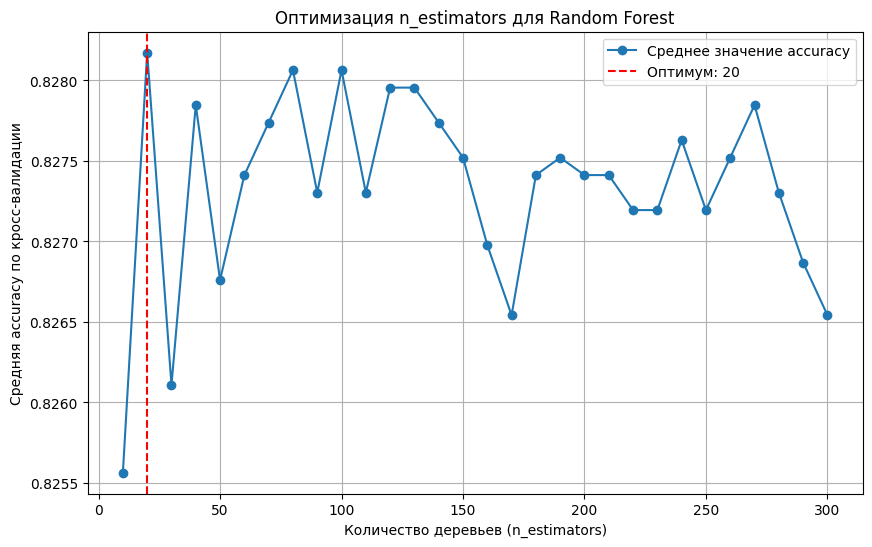

In [ ]:
max_trees = 300
tree_range = np.arange(10, max_trees + 1, 10) 

for n_trees in tree_range:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42, n_jobs=-1)
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_n_estimators = tree_range[np.argmax(cv_scores)]
print(f"Оптимальное количество деревьев: {optimal_n_estimators}")

plt.figure(figsize=(10, 6))
plt.plot(tree_range, cv_scores, marker='o', label="Среднее значение accuracy")
plt.axvline(optimal_n_estimators, color='r', linestyle='--', label=f"Оптимум: {optimal_n_estimators}")
plt.xlabel("Количество деревьев (n_estimators)")
plt.ylabel("Средняя accuracy по кросс-валидации")
plt.title("Оптимизация n_estimators для Random Forest")
plt.legend()
plt.grid()
plt.show()

<div style="border: 1px solid red; padding: 10px; border-radius: 5px;">

Теперь подберите следующие оптимальные параметры:
- максимальная глубина решающего дерева (*max_depth*)
- функция оценки качества разбиения (*criterion*)
- максимальное количесво учитываемых признаков при разбиении (*max_features*)

Остальные параметры оставляйте по умолчанию, за исключением парамтра `n_estimators` для случайного леса, выбранного на предыдущем шаге.

Оцените скорость обучения каждого из алгоритмов. Для этого воспользуйтесь графиком вида "ящик с усами", который отражает среднее время обучения алгоритма при фиксированном значении гиперпараметров. Что вы можете сказать о скорости работы алгоритмов? Почему наблюдаются такие результаты? Можно ли ускорить? Если да, то каким образом?

</div>

Лучшие параметры:
 max_depth           10.0
criterion        entropy
max_features        log2
accuracy        0.848278
train_time      0.396515
Name: 8, dtype: object


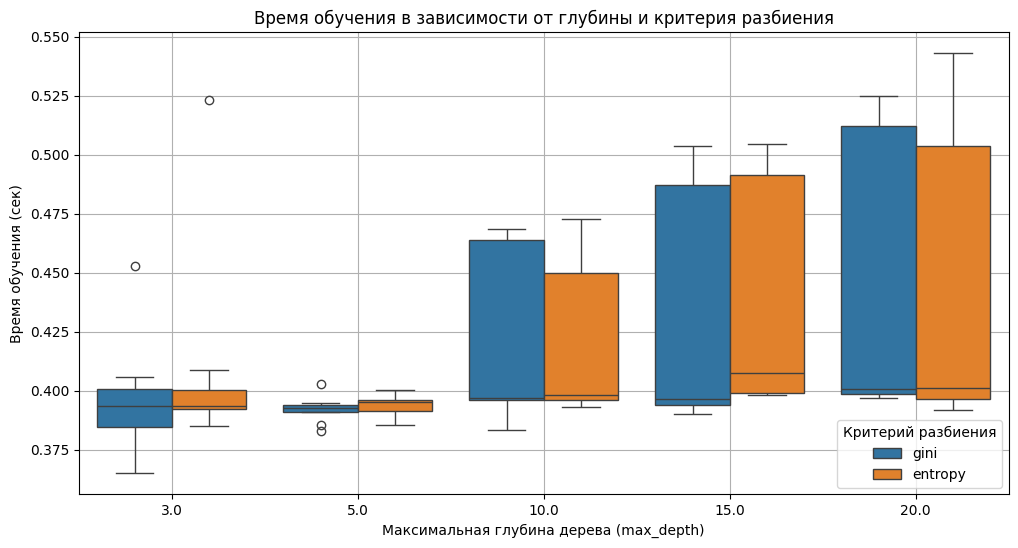

In [69]:
n_estimators_optimal = 20
depth_range = [3, 5, 10, 15, 20, None]
criterion_options = ['gini', 'entropy']
features_range = ['sqrt', 'log2', None]
results = []

for _ in range(3):
    for depth in depth_range:
        for criterion in criterion_options:
            for max_features in features_range:
                model = RandomForestClassifier(
                    n_estimators=n_estimators_optimal,
                    max_depth=depth,
                    criterion=criterion,
                    max_features=max_features,
                    random_state=42,
                    n_jobs=-1
                )
                start_time = time.time()
                scores = cross_val_score(
                    model, 
                    X_train, 
                    y_train, 
                    cv=5, 
                    scoring='accuracy'
                )
                end_time = time.time()
                
                results.append({
                    "max_depth": depth,
                    "criterion": criterion,
                    "max_features": max_features,
                    "accuracy": scores.mean(),
                    "train_time": end_time - start_time
                })

results_df = pd.DataFrame(results)
grouped_df = results_df.groupby(['max_depth', 'criterion', 'max_features']).agg({
    'accuracy': 'mean',
    'train_time': 'mean'
}).reset_index()

best_params = grouped_df.loc[grouped_df['accuracy'].idxmax()]
print("Лучшие параметры:\n", best_params)

plt.figure(figsize=(12, 6))
sns.boxplot(x="max_depth", y="train_time", hue="criterion", data=results_df)
plt.xlabel("Максимальная глубина дерева (max_depth)")
plt.ylabel("Время обучения (сек)")
plt.title("Время обучения в зависимости от глубины и критерия разбиения")
plt.legend(title="Критерий разбиения")
plt.grid()
plt.show()

- На графике видно, что время обучения увеличивается с ростом глубины дерева. Чем больше глубина дерева, тем больше рекурсивных разбиений требуется, что увеличивает время обучения.
- Использование критериев `entropy` и `gini` в данном случае примерно равнозначно по времени.
- Можно попробовать ускорить ограничив глубину деревьев до разумного значения (10-15).

<div style="border: 1px solid red; padding: 10px; border-radius: 5px;">

## Сравнение результатов

Сравните результаты алгоритмов. Для этого воспользуйтесь "ящиком с усами" (boxplot).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

</div>

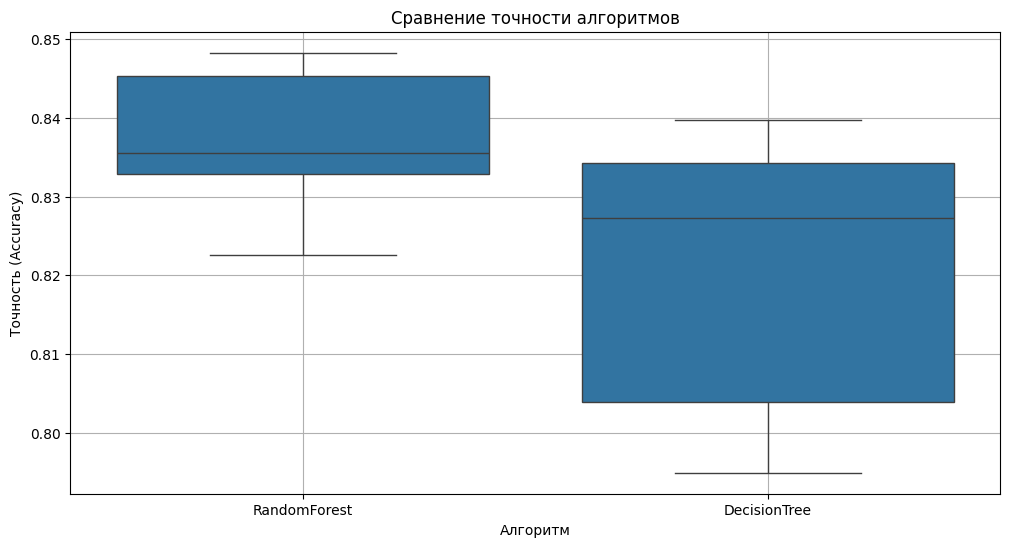

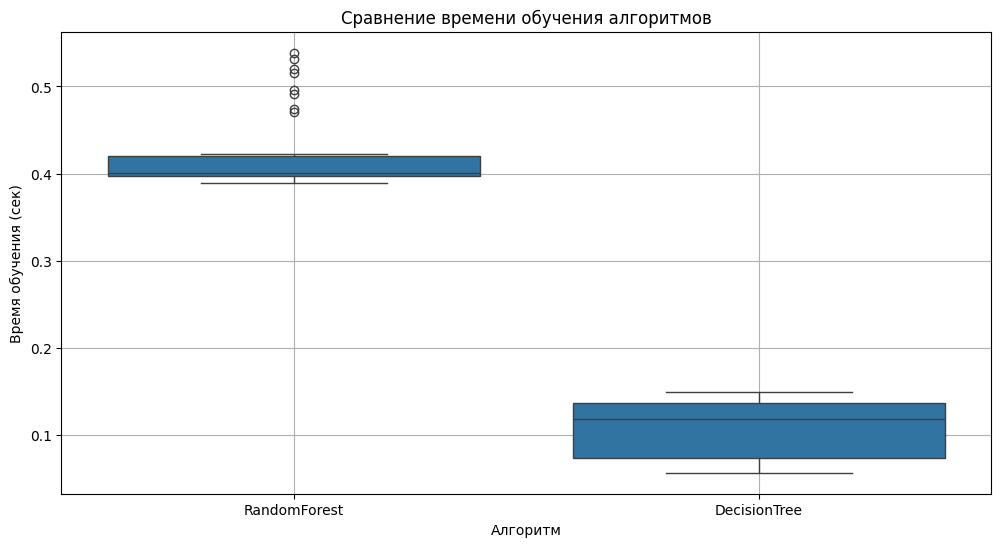

In [ ]:
n_estimators_optimal = 20
depth_range = [3, 5, 10, 15, 20, None]
criterion_options = ['gini', 'entropy']
features_range = ['sqrt', 'log2', None]

rf_results = []
for depth in depth_range:
    for criterion in criterion_options:
        for max_features in features_range:
            model = RandomForestClassifier(
                n_estimators=n_estimators_optimal,
                max_depth=depth,
                criterion=criterion,
                max_features=max_features,
                random_state=42,
                n_jobs=-1
            )
            start_time = time.time()
            scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
            end_time = time.time()
            rf_results.append({
                "algorithm": "RandomForest",
                "max_depth": depth,
                "criterion": criterion,
                "max_features": max_features,
                "accuracy": scores.mean(),
                "train_time": end_time - start_time
            })

dt_results = []
for depth in depth_range:
    for criterion in criterion_options:
        model = DecisionTreeClassifier(
            max_depth=depth,
            criterion=criterion,
            random_state=42
        )
        start_time = time.time()
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        end_time = time.time()
        dt_results.append({
            "algorithm": "DecisionTree",
            "max_depth": depth,
            "criterion": criterion,
            "accuracy": scores.mean(),
            "train_time": end_time - start_time
        })
results_df = pd.DataFrame(rf_results + dt_results)

plt.figure(figsize=(12, 6))
sns.boxplot(x="algorithm", y="accuracy", data=results_df)
plt.xlabel("Алгоритм")
plt.ylabel("Точность (Accuracy)")
plt.title("Сравнение точности алгоритмов")
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x="algorithm", y="train_time", data=results_df)
plt.xlabel("Алгоритм")
plt.ylabel("Время обучения (сек)")
plt.title("Сравнение времени обучения алгоритмов")
plt.grid()
plt.show()

**Сравнение точности алгоритмов:**
- RandomForest:
    - Показывает более высокую точность (около 0.84-0.85) по сравнению с DecisionTree.
    - Это связано с тем, что RandomForest усредняет множество деревьев, что снижает риск переобучения и улучшает обобщающую способность модели.
- DecisionTree:
    - Показывает более низкую точность (около 0.81-0.82).
    - Это связано с тем, что одно дерево может переобучаться на обучающих данных, особенно если глубина дерева слишком большая.
  
**Вывод:** RandomForest более точен и устойчив к переобучению, чем DecisionTree.

**Сравнение времени обучения алгоритмов:**
- RandomForest:
    - Обучается значительно дольше, чем DecisionTree.
    - Это связано с тем, что RandomForest строит множество деревьев, что требует больше вычислительных ресурсов.
- DecisionTree:
    - Обучается быстрее, так как строит только одно дерево.
    - Это делает DecisionTree более подходящим для задач, где важна скорость.

**Вывод:** DecisionTree быстрее обучается, но RandomForest обеспечивает более высокое качество.

**Влияние гиперпараметров:**
- RandomForest:
    - Гиперпараметры (max_depth, criterion, max_features) влияют на качество и время обучения.
    - Например, увеличение max_depth может улучшить качество, но замедлить обучение.
- DecisionTree:
    - Гиперпараметры (max_depth, criterion) также влияют на качество и время обучения.
    - Например, увеличение max_depth может привести к переобучению.

<div style="border: 1px solid red; padding: 10px; border-radius: 5px;">

## Тестирование всех моделей

Протестируйте последние построенные модели (наилучшее решающее дерево и наилучший случайный лес) на данных, которые были отложены для теста (их должно было остаться 40%). Не забудьте про все необходимые преобразования.

</div>

In [70]:
optimal_tree_depth = 6
optimal_criterion = 'entropy'
optimal_max_features = 'log2'
best_tree = DecisionTreeClassifier(max_depth=optimal_tree_depth, random_state=42)
best_tree.fit(X_train, y_train)

best_rf = RandomForestClassifier(n_estimators=optimal_n_estimators, max_depth=optimal_tree_depth, 
                                 criterion=optimal_criterion, max_features=optimal_max_features, 
                                 random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

y_pred_tree = best_tree.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

print("Результаты для лучшего дерева решений:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree):.4f}")
print(classification_report(y_test, y_pred_tree))

print("\nРезультаты для лучшего случайного леса:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

Результаты для лучшего дерева решений:
Accuracy: 0.8502
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      4630
           1       0.78      0.54      0.64      1504

    accuracy                           0.85      6134
   macro avg       0.82      0.75      0.77      6134
weighted avg       0.84      0.85      0.84      6134


Результаты для лучшего случайного леса:
Accuracy: 0.8547
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4630
           1       0.78      0.56      0.65      1504

    accuracy                           0.85      6134
   macro avg       0.83      0.76      0.78      6134
weighted avg       0.85      0.85      0.85      6134

